In [1]:
import keras
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization
import keras.backend as K
from keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
from PIL import Image
import scipy.io as sio
import matplotlib.pyplot as plt

/home/aidan/anaconda3/envs/py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
stuff = sio.loadmat("./data/mall/mall_gt.mat")

This gives the actual count of people in the image

In [3]:
def get_head_count(frame_num: int):
    return stuff["count"][frame_num][0]

Gets the information for the locations of people in the frame

In [4]:
def get_head_locations(frame_num: int):
    return stuff["frame"][0][frame_num][0][0][0].round().astype(int)

In [5]:
def frame_to_array(frame_num: int):
    img = Image.open("./data/mall/frames/seq_{}.jpg".format(str(frame_num+1).zfill(6)))
    img.load()
    data = np.asarray( img, dtype="int32" )
    data = data / 255
    return data

In [6]:
def loc_to_img_arr(loc_arr, img_arr):
    base_arr = np.zeros(shape=(img_arr.shape[0]//4, img_arr.shape[1]//4))
    for pos in loc_arr:
        base_arr[pos[1]//4][pos[0]//4] = 1
    base_arr = np.expand_dims(base_arr, axis=-1)
    return base_arr

In [7]:
def get_full_frame(frame_num: int):
    frame_arr = frame_to_array(frame_num)
    loc_arr = get_head_locations(frame_num)
    loc_img_arr = loc_to_img_arr(loc_arr, frame_arr)
    return {
        "locations": loc_arr,
        "loc_img": loc_img_arr,
        "image": frame_arr
    }
print(get_full_frame(1)["loc_img"].shape)

(120, 160, 1)


In [8]:
loc_arr = np.zeros(shape=(1000, 120, 160, 1))
img_arr = np.zeros(shape=(1000, 480, 640, 3))
for i in range(1000):
    frame = get_full_frame(i)
    loc_arr[i] = frame["loc_img"]
    img_arr[i] = frame["image"]
    print("Done with {}".format(i))

Done with 0
Done with 1
Done with 2
Done with 3
Done with 4
Done with 5
Done with 6
Done with 7
Done with 8
Done with 9
Done with 10
Done with 11
Done with 12
Done with 13
Done with 14
Done with 15
Done with 16
Done with 17
Done with 18
Done with 19
Done with 20
Done with 21
Done with 22
Done with 23
Done with 24
Done with 25
Done with 26
Done with 27
Done with 28
Done with 29
Done with 30
Done with 31
Done with 32
Done with 33
Done with 34
Done with 35
Done with 36
Done with 37
Done with 38
Done with 39
Done with 40
Done with 41
Done with 42
Done with 43
Done with 44
Done with 45
Done with 46
Done with 47
Done with 48
Done with 49
Done with 50
Done with 51
Done with 52
Done with 53
Done with 54
Done with 55
Done with 56
Done with 57
Done with 58
Done with 59
Done with 60
Done with 61
Done with 62
Done with 63
Done with 64
Done with 65
Done with 66
Done with 67
Done with 68
Done with 69
Done with 70
Done with 71
Done with 72
Done with 73
Done with 74
Done with 75
Done with 76
Done with

Done with 609
Done with 610
Done with 611
Done with 612
Done with 613
Done with 614
Done with 615
Done with 616
Done with 617
Done with 618
Done with 619
Done with 620
Done with 621
Done with 622
Done with 623
Done with 624
Done with 625
Done with 626
Done with 627
Done with 628
Done with 629
Done with 630
Done with 631
Done with 632
Done with 633
Done with 634
Done with 635
Done with 636
Done with 637
Done with 638
Done with 639
Done with 640
Done with 641
Done with 642
Done with 643
Done with 644
Done with 645
Done with 646
Done with 647
Done with 648
Done with 649
Done with 650
Done with 651
Done with 652
Done with 653
Done with 654
Done with 655
Done with 656
Done with 657
Done with 658
Done with 659
Done with 660
Done with 661
Done with 662
Done with 663
Done with 664
Done with 665
Done with 666
Done with 667
Done with 668
Done with 669
Done with 670
Done with 671
Done with 672
Done with 673
Done with 674
Done with 675
Done with 676
Done with 677
Done with 678
Done with 679
Done w

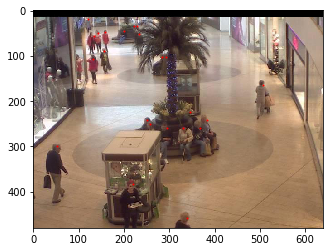

In [10]:
frame = get_full_frame(600)
img = frame["image"]
loc = frame["locations"]
loc_img = frame["loc_img"]
plt.imshow(np.reshape(loc_img, (120, 160)), interpolation='nearest')
plt.imshow(img, interpolation='nearest')
for pos in loc:
    #print(pos)
    plt.scatter(pos[0], pos[1], s=1, c='red', marker='o')
    pass
plt.show()

In [11]:
def customLoss(yTrue, yPred):
    dims = K.int_shape(yPred)
    n = dims[0] if dims[0] is not None else 1
    print("dims: {}".format(dims))
    total = 0
    for i in range(n):
        total += K.sum(K.square(yTrue[i] - yPred[i]))
    return (1/(2*n)) * total


base_arr = np.zeros((1, 120, 160, 1))
base_arr[0] = get_full_frame(0)["loc_img"]
true = tf.convert_to_tensor(base_arr)
sample_pred = tf.convert_to_tensor(np.zeros((1, 120, 160, 1)))
t = customLoss(true, sample_pred)

init_op = tf.initialize_all_variables()
with tf.Session() as sess:
    sess.run(init_op)
    print (sess.run(t))

dims: (1, 120, 160, 1)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
14.5


In [12]:
def custom_loss(yTrue, yPred):
    diff_sums = K.sum(K.sum(K.square(yTrue-yPred), axis=[1,2]))
    return diff_sums

def custom_loss_final(yTrue, yPred):
    diff_sums = K.sum(K.square(yTrue-yPred))
    return diff_sums

def custom_loss_nsquare(yTrue, yPred):
    diff_sums = K.sum(yTrue-yPred, axis=[1,2])
    return diff_sums

base_arr = np.zeros((3, 120, 160, 1))
base_arr[0] = get_full_frame(0)["loc_img"]
base_arr[1] = get_full_frame(500)["loc_img"]
base_arr[2] = get_full_frame(1000)["loc_img"]
true = tf.convert_to_tensor(base_arr)
sample_pred = tf.convert_to_tensor(np.zeros((3, 120, 160, 1)))
sample_pred_rand = tf.convert_to_tensor(np.random.randint(2, size=(3, 120, 160, 1)).astype("float"))
t = custom_loss(true, true)
g = custom_loss_final(true, sample_pred_rand)

with tf.Session() as sess:
    an = sess.run(t)
    print(an)
    print(an.shape)
    an = sess.run(g)
    print(an)
    print(an.shape)

0.0
()
28849.0
()


In [13]:
print(img_arr.shape)
print(loc_arr.shape)

(1000, 480, 640, 3)
(1000, 120, 160, 1)


In [14]:
input_img = Input(shape=(480, 640, 3))
x = Conv2D(16, (9, 9), activation='relu' , padding="same")(input_img)
x = BatchNormalization()(x)
x = Conv2D(16, (9, 9), activation='relu' , padding="same")(input_img)
x = BatchNormalization()(x)
x = Conv2D(16, (9, 9), activation='relu' , padding="same")(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(32, (7, 7), activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(32, (7, 7), activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(32, (7, 7), activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(16, (7, 7), activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(16, (7, 7), activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(8, (7, 7), activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(8, (7, 7), activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(1, (1,1), activation='relu', padding="same")(x)


stop_here_please = EarlyStopping(patience=2, monitor="loss")
m = Model(input_img, x)
m.compile(optimizer='adam', loss=custom_loss_final)
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 480, 640, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 480, 640, 16)      3904      
_________________________________________________________________
batch_normalization_3 (Batch (None, 480, 640, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 240, 320, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 240, 320, 32)      25120     
_________________________________________________________________
batch_normalization_4 (Batch (None, 240, 320, 32)      128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 240, 320, 32)      50208     
__________

In [ ]:
m.fit(img_arr, loc_arr, epochs=100, batch_size=10, callbacks=[stop_here_please])

Epoch 1/100
1000/1000 [==============================] - 71s 71ms/step - loss: 8133.0623
Epoch 2/100
1000/1000 [==============================] - 69s 69ms/step - loss: 317.6888
Epoch 3/100
 200/1000 [=====>........................] - ETA: 50s - loss: 314.3766

In [26]:
# m.save("v2.h5")

(3, 480, 640, 3)
(3, 120, 160, 1)
1.2663363


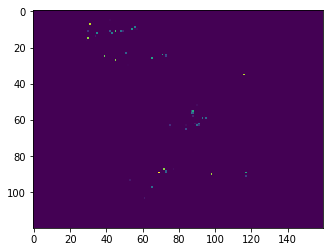

24.37343


In [35]:
frame = get_full_frame(500)
n = np.zeros((3, 480, 640, 3))
n[0] = get_full_frame(500)["image"]
n[1] = get_full_frame(1000)["image"]
n[2] = get_full_frame(1500)["image"]
print(n.shape)
out = m.predict(n)
print(out.shape)
out = out.reshape(3, 120, 160)
print(np.amax(out))
plt.imshow(out[0], interpolation='nearest')
plt.show()
print(np.sum(out[2]))

In [44]:
true_num = len(get_full_frame(1500)["locations"])
pred = out[2]
num_pred = len(np.argwhere(pred>0))
threshold = 0
while num_pred > true_num:
    threshold += 0.01
    num_pred = len(np.argwhere(pred>threshold))
    print("At: {}".format(threshold))

At: 0.01
At: 0.02
At: 0.03
At: 0.04
At: 0.05
At: 0.060000000000000005
At: 0.07
At: 0.08
At: 0.09
At: 0.09999999999999999
At: 0.10999999999999999
At: 0.11999999999999998
At: 0.12999999999999998


In [42]:
pred = np.argwhere(pred>0.35)
pred = np.argwhere(pred>0.25)
pred = np.argwhere(pred>0.13)
print(len(pred))

26


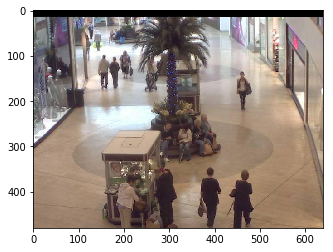

In [33]:
plt.imshow(n[0])

In [60]:
import keras.losses
keras.losses.custom_loss_final = custom_loss_final
model = load_model("v2.h5")

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.


OSError: Unable to open file (unable to open file: name = 'v2.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

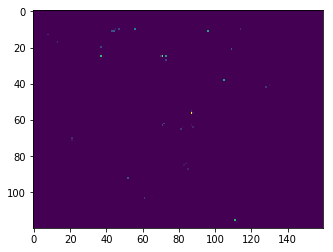

In [48]:
def get_prediction(frame_num):
    frame = get_full_frame(frame_num)
    img = np.zeros((1, 480, 640, 3))
    img[0] = frame["image"]
    out = model.predict(img)[0].reshape((120, 160))
    
    return {
        "image": frame["image"],
        "pred_density": out,
        "true_density": frame["loc_img"].reshape((120, 160)),
        "locations": frame["locations"]
    }
    
prediction = get_prediction(1999)
predicted = prediction["pred_density"]

plt.imshow(predicted)

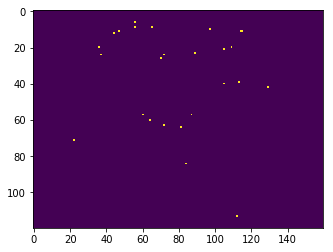

In [49]:
plt.imshow(prediction["true_density"])

In [55]:
prediction = get_prediction(0)
pred_density = prediction["pred_density"]
true_density = prediction["true_density"]
true_locations = prediction["locations"]
base_image = prediction["image"]

In [56]:
print(np.sum(pred_density))
print(np.sum(true_density))

20.793524
29.0


In [59]:
total_error = 0
for i in range(2000):
    prediction = get_prediction(i)
    pred_num = np.sum(prediction["pred_density"])
    true_num = np.sum(prediction["true_density"])
    total_error += abs(pred_num-true_num)
    print("Average error: {}".format(total_error/(i+1)))

print("True error: {}".format(total_error/2000))

Average error: 8.206476211547852
Average error: 5.75102424621582
Average error: 5.903640111287435
Average error: 6.82193660736084
Average error: 6.0906940460205075
Average error: 5.891176223754883
Average error: 5.489355087280273
Average error: 5.015878438949585
Average error: 4.900928497314453
Average error: 4.789500427246094
Average error: 4.9924585169011895
Average error: 5.377563953399658
Average error: 5.453236946692834
Average error: 5.862848554338727
Average error: 6.119855626424154
Average error: 6.376834988594055
Average error: 6.70953301822438
Average error: 7.098963949415419
Average error: 7.1138669064170434
Average error: 7.190875148773193
Average error: 7.007132303147089
Average error: 7.019840413873846
Average error: 7.133594512939453
Average error: 7.27881932258606
Average error: 7.29126220703125
Average error: 7.285413448627178
Average error: 7.504419538709852
Average error: 7.559255940573556
Average error: 7.440626736344962
Average error: 7.529384167989095
Average erro

Average error: 5.058917176489737
Average error: 5.058526702225208
Average error: 5.053759508095826
Average error: 5.053447072820146
Average error: 5.036578601851887
Average error: 5.028495333744929
Average error: 5.023323205239015
Average error: 5.02314700789124
Average error: 5.007772685003824
Average error: 5.000395001787128
Average error: 4.998888152500369
Average error: 4.995838487954964
Average error: 5.011228297087137
Average error: 5.011773735729616
Average error: 5.015163719432505
Average error: 5.026942676968044
Average error: 5.019149540975085
Average error: 5.029990771237542
Average error: 5.036156518118722
Average error: 5.035030594707406
Average error: 5.0467576252330435
Average error: 5.040412349977355
Average error: 5.0283024991032015
Average error: 5.015292716540879
Average error: 5.0141652220038955
Average error: 5.004439047404698
Average error: 5.00842018738336
Average error: 5.004082872512493
Average error: 5.0114797956109465
Average error: 5.006687228108795
Average 

Average error: 5.941742665211674
Average error: 5.946772880102756
Average error: 5.9392977868478125
Average error: 5.944500698321929
Average error: 5.94712906070784
Average error: 5.942967635078206
Average error: 5.947648758068681
Average error: 5.951561734457927
Average error: 5.966821290175739
Average error: 5.986493784710041
Average error: 5.992299151975055
Average error: 6.000782350506958
Average error: 6.007573321058944
Average error: 6.021570464779187
Average error: 6.024784830900339
Average error: 6.0224713180893445
Average error: 6.02973587028825
Average error: 6.029543800062249
Average error: 6.0308282994132005
Average error: 6.038370857238769
Average error: 6.041419756276526
Average error: 6.052686425268763
Average error: 6.064296019799782
Average error: 6.068166839152518
Average error: 6.0584902511452725
Average error: 6.058840399632571
Average error: 6.058486714398951
Average error: 6.060612871767656
Average error: 6.061284620663646
Average error: 6.059630672062669
Average 

Average error: 6.4932508656853125
Average error: 6.506267751876691
Average error: 6.51787657374785
Average error: 6.525079645929299
Average error: 6.530298498912631
Average error: 6.537352534524755
Average error: 6.543035789818427
Average error: 6.548537622374693
Average error: 6.554622850070397
Average error: 6.558654731829858
Average error: 6.56043008209823
Average error: 6.56147519098027
Average error: 6.565580386571933
Average error: 6.563022333468379
Average error: 6.565037319518491
Average error: 6.568033768438524
Average error: 6.578864757547674
Average error: 6.588657544846701
Average error: 6.591924680842226
Average error: 6.595300731977235
Average error: 6.6015327221308
Average error: 6.609841073215694
Average error: 6.6155012269763995
Average error: 6.619202431134338
Average error: 6.626183890566534
Average error: 6.632478904724121
Average error: 6.630900634154108
Average error: 6.6374813150117475
Average error: 6.64259186735008
Average error: 6.644793129692513
Average error

Average error: 7.42123024062355
Average error: 7.428250096789925
Average error: 7.432484725718441
Average error: 7.431192346292328
Average error: 7.432934983947574
Average error: 7.436865489001344
Average error: 7.43956862190577
Average error: 7.443011023184777
Average error: 7.4453431590366925
Average error: 7.450843909303854
Average error: 7.45325602830625
Average error: 7.455034862185785
Average error: 7.45814984371984
Average error: 7.461579550279783
Average error: 7.4664429081603885
Average error: 7.474598223988603
Average error: 7.481171192481503
Average error: 7.487846130289377
Average error: 7.498106849796577
Average error: 7.508165454957181
Average error: 7.52231895576403
Average error: 7.527454549195579
Average error: 7.53374333437099
Average error: 7.541197800797853
Average error: 7.545795323539749
Average error: 7.551818747220984
Average error: 7.557956309852453
Average error: 7.567019138869577
Average error: 7.56684380735276
Average error: 7.573882247990892
Average error: 

Average error: 8.599896548100395
Average error: 8.600405166003785
Average error: 8.60764745443682
Average error: 8.61544469825835
Average error: 8.618228465648247
Average error: 8.624281458715425
Average error: 8.631308058458924
Average error: 8.636439954699073
Average error: 8.642926293470728
Average error: 8.652345893703794
Average error: 8.657693857666832
Average error: 8.665037463054073
Average error: 8.669861002282781
Average error: 8.67810718386781
Average error: 8.683154447699042
Average error: 8.691544547712047
Average error: 8.693767163302043
Average error: 8.697662018723
Average error: 8.701863097399473
Average error: 8.707699058020514
Average error: 8.711023651307533
Average error: 8.72007213452786
Average error: 8.729313393619574
Average error: 8.7387005230796
Average error: 8.740895617620014
Average error: 8.741041130860276
Average error: 8.74451178201237
Average error: 8.747875204744776
Average error: 8.748631147635999
Average error: 8.753108796548881
Average error: 8.751

Average error: 9.543634422226708
Average error: 9.550034919326098
Average error: 9.551975147144214
Average error: 9.554659266716879
Average error: 9.557534291290624
Average error: 9.56135965021033
Average error: 9.562299490131727
Average error: 9.564590284921493
Average error: 9.56509436859712
Average error: 9.569049813303108
Average error: 9.568835562408948
Average error: 9.570994317765942
Average error: 9.571361549867081
Average error: 9.57377594740603
Average error: 9.576590924733912
Average error: 9.57869142582214
Average error: 9.58113835731571
Average error: 9.582881382800268
Average error: 9.587720581696692
Average error: 9.592715881949454
Average error: 9.596065772861145
Average error: 9.599112045640746
Average error: 9.59956424703207
Average error: 9.606574163325277
Average error: 9.611532713857233
Average error: 9.615990146414026
Average error: 9.618574497066946
Average error: 9.622930318310413
Average error: 9.62822349397532
Average error: 9.630416407486317
Average error: 9.

Average error: 10.337341058423094
Average error: 10.340381299922852
Average error: 10.343964922677749
Average error: 10.349695579498603
Average error: 10.354968439191664
Average error: 10.359967751152771
Average error: 10.362277085332801
Average error: 10.363196357916493
Average error: 10.3667167979852
Average error: 10.372351904463741
Average error: 10.376279910987531
Average error: 10.379390849186494
Average error: 10.382990180205011
Average error: 10.38621005539953
Average error: 10.390797342189984
Average error: 10.394238836309883
Average error: 10.399153855595275
Average error: 10.40236730072501
Average error: 10.407184095912212
Average error: 10.409772887892787
Average error: 10.41411343208548
Average error: 10.419496583244435
Average error: 10.42162660386353
Average error: 10.424722296012861
Average error: 10.428746303944298
Average error: 10.431882699508241
Average error: 10.433098088556799
Average error: 10.433962198240417
Average error: 10.437256797624578
Average error: 10.44